In [1]:
import math
from random import sample

import numpy as np
import pandas as pd

from datetime import datetime
from datetime import timedelta

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as Gridspec
plt.style.use('../util/matplotlib_stylesheet.mplstyle')

# Monte Carlo Optimization of Perfect Scheduling
Monte Carlo optimization algorithm to ideally distribute a number of clients over a given number of rounds.
Every client is guaranteed to participate in the given number of rounds.
The optimized scheduling approaches the ideal scheduling with the lowest possible carbon footprint

In [2]:
def monte_carlo_optimize(initial_scheduling, cost, quench=0.0001, term_std=0.01, term_n=100, force_equal_distribution=True):

    ### Initialisation

    current_scheduling = initial_scheduling.copy()
    initial_cost = (initial_scheduling*cost).sum()

    cost_history = np.array([initial_cost])

    monte_round = 0

    ### Monte Carlo Loop: Randomly reshuffle the scheduling, compare to old and new one, go on with the better (less carbon) one

    while monte_round := monte_round + 1:
        new_scheduling = current_scheduling.copy()

        ### In the beginning, with smaller monte_round numbers, more clients are shuffled around. With increasing monte_round less clients are shuffled, this is controlled by the quench parameter
        clients_shuffle_number = int((1/(quench*monte_round))*current_scheduling.shape[0])

        clients_shuffled = []
        for client_shuffle_round in range(0, clients_shuffle_number):
            if len(clients_shuffled) == current_scheduling.shape[0]: ### Make sure each client is only shuffled once per monte_round. This is for performance reasons only
                break
            random_client_pick = sample(list(range(0,current_scheduling.shape[0])), 1)[0]
            if random_client_pick not in clients_shuffled:    ### Make sure each client is only shuffled once per monte_round. This is for performance reasons only
                clients_shuffled.append(random_client_pick)

                random_round_pick_1 = sample(list(range(0,current_scheduling.shape[1])), 1)[0]
                random_round_pick_2 = sample(list(range(0,current_scheduling.shape[1])), 1)[0]

                if not (random_round_pick_1 == random_round_pick_2):
                    new_scheduling[random_client_pick, random_round_pick_1], new_scheduling[random_client_pick, random_round_pick_2] = new_scheduling[random_client_pick, random_round_pick_2], new_scheduling[random_client_pick, random_round_pick_1]

        ### Compare the new ond old carbon footprint
        old_cost = (current_scheduling*cost).sum()
        new_cost = (new_scheduling*cost).sum()

        ### fore_equal_distribution=True forces the clients to be evenly distributed over all rounds. In particular, new scheduling is only accepted if the conditions for evenyl spaced client distribution is fulfilled

        if force_equal_distribution:
            monte_carlo_condition = (new_cost <= old_cost) and (new_scheduling.sum(axis=0) <= math.ceil(number_of_clients/number_of_rounds)).all() and (new_scheduling.sum(axis=0) >= int(number_of_clients/number_of_rounds)).all()
        else:
            monte_carlo_condition = (new_cost <= old_cost)

        if monte_carlo_condition:
            cost_history = np.append(cost_history, [new_cost])
            current_scheduling = new_scheduling


        ### Stop the monte carlo optimization if the last term_n number of new schedulings vary by a standard deviation less than term_std

        stop_condition = (cost_history[-term_n:].std() < term_std) and (len(cost_history) >= term_n)

        if stop_condition:
            break

    return current_scheduling, pd.Series(cost_history), monte_round

In [3]:
#every client (number_of_clients in total) runs ONCE in the next number_of_rounds
number_of_rounds = 5
number_of_clients = 100

In [4]:
time = np.array([np.linspace(0, 10, number_of_rounds) for i in range(0, number_of_clients)])
wavelength = np.random.random((number_of_clients, 1)) * 0.8
shift = np.random.random((number_of_clients,1)) * 100
cost = np.sin((time-shift)*wavelength) + 1

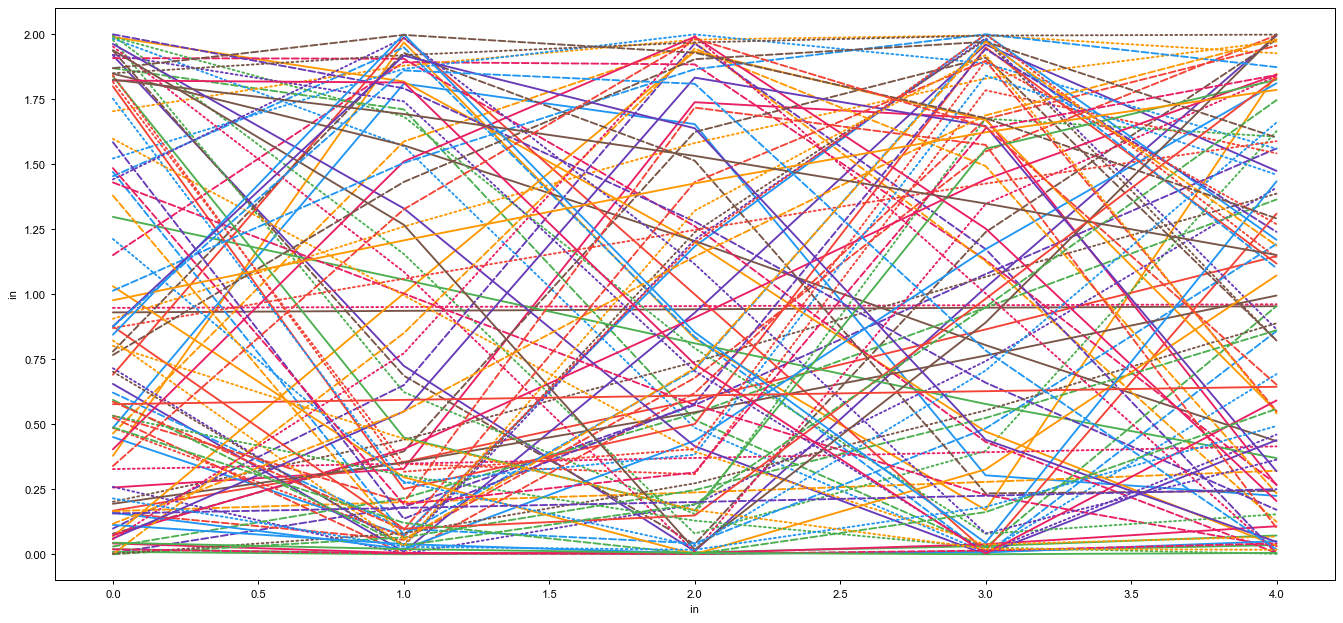

In [5]:
debug_plot_01 = plt.figure(figsize=(15, 7))
debug_plot_01.set_tight_layout(True)
debug_plot_01_ax1 = debug_plot_01.add_subplot(1, 1, 1)
debug_plot_01_ax1.set_xlabel(' in ')
debug_plot_01_ax1.set_ylabel(' in ')

for i, j in enumerate(cost):
    debug_plot_01_ax1.plot(j, label=i)

# debug_plot_01_ax1.legend()

In [6]:
random_scheduling = np.zeros((number_of_clients, number_of_rounds), dtype=int)

#### random scheduling

for i in range(random_scheduling.shape[0]):
    random_round_pick = sample(list(range(0, random_scheduling.shape[1])), 1)[0]
    random_scheduling[i, random_round_pick] = 1

#### precondition the random scheduling to have a uniformely distribution of clients each round

while not ((random_scheduling.sum(axis=0) <= math.ceil(number_of_clients / number_of_rounds)).all() and (random_scheduling.sum(axis=0) >= int(number_of_clients / number_of_rounds)).all()):
    for client_shuffle in range(math.ceil(random_scheduling.shape[0] / 2)):
        random_client_pick = sample(list(range(0, random_scheduling.shape[0])), 1)[0]
        random_round_pick_1 = sample(list(range(0, random_scheduling.shape[1])), 1)[0]
        random_round_pick_2 = sample(list(range(0, random_scheduling.shape[1])), 1)[0]
        if not (random_round_pick_1 == random_round_pick_2):
            random_scheduling[random_client_pick, random_round_pick_1], random_scheduling[random_client_pick, random_round_pick_2] = random_scheduling[random_client_pick, random_round_pick_2], random_scheduling[random_client_pick, random_round_pick_1]




print('Preconditioning complete')

Preconditioning complete


In [7]:
#### number of clients each round in the random_scheduling after preconditioning
random_scheduling.sum(axis=0)

array([20, 20, 20, 20, 20])

In [8]:
quench_values = [0.0001, 0.001, 0.01, 0.1]
benchmarks = [monte_carlo_optimize(random_scheduling, cost, quench=quench_value) for quench_value in quench_values]

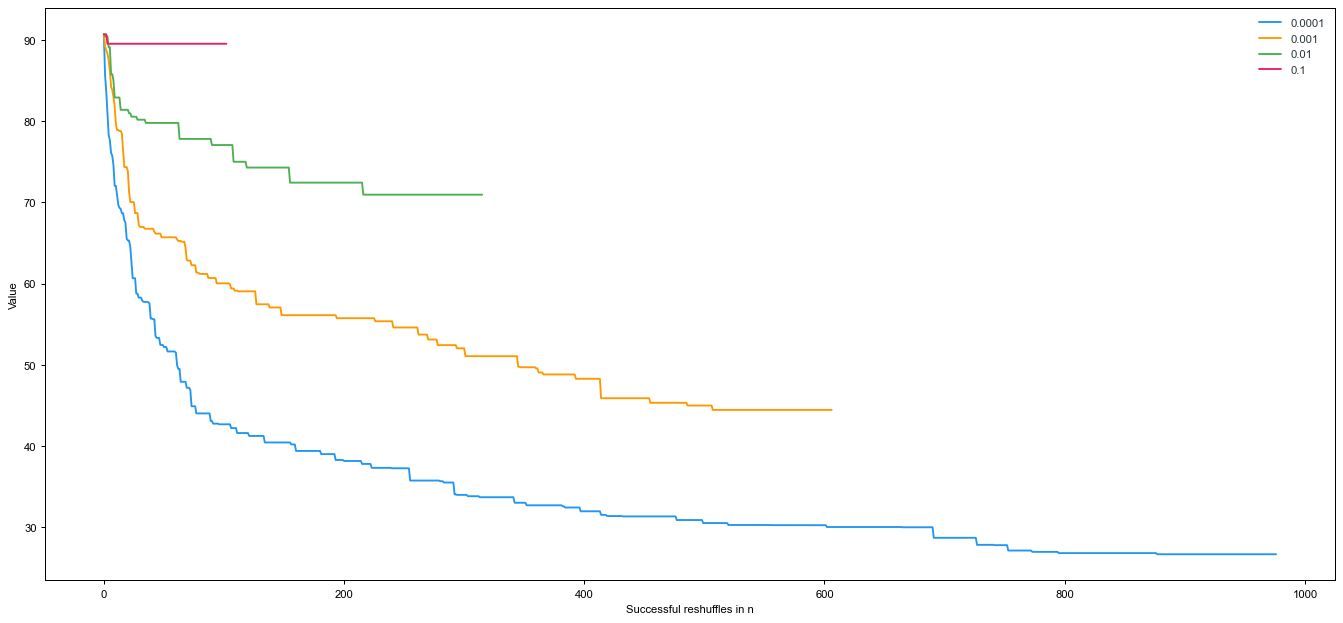

In [9]:
debug_plot_02 = plt.figure(figsize=(15, 7))
debug_plot_02.set_tight_layout(True)
debug_plot_02_ax1 = debug_plot_02.add_subplot(1, 1, 1)
debug_plot_02_ax1.set_xlabel('Successful reshuffles in n')
debug_plot_02_ax1.set_ylabel('Value')

for benchmark, quench_value in zip(benchmarks, quench_values):
    debug_plot_02_ax1.plot(range(len(benchmark[1])),benchmark[1], label=quench_value)

debug_plot_02_ax1.legend()

**As the CarbonSDK_WebAPI is not longer part of the lowcarb framework this is included here**

In [10]:
from typing import List
import requests

from pandas import DataFrame


from dateutil import parser

from carbon_sdk_client.openapi_client.api.carbon_aware_api import CarbonAwareApi
from carbon_sdk_client.openapi_client.api_client import ApiClient
from carbon_sdk_client.openapi_client.configuration import Configuration

class CarbonSDK_WebAPI():
    strftime = '%Y-%m-%dT%H:%M:%S'

    def __init__(self, url='https://carbon-aware-api.azurewebsites.net'):
        self.url = url
        self.api_client = ApiClient(configuration=Configuration(host=self.url))
        self.api_instance = CarbonAwareApi(self.api_client)

    def get_forecast(self, region: str, windowSize: int, forecast_window=None) -> DataFrame:
        '''
        Fetches forecast from the carbon_sdk and merges it into a pandas Dataframe


        :param region: string of the region -> Free version of WhattTime only allows 'westis'
        :param windowSize: expected time of the workload in minutes
        :return: pandas Dataframe with 'time' and 'carbon value' column
        :raises: raises InvalidSchemaif anything goes wrong
        '''

        if forecast_window:
            forecast_window = 22 if (forecast_window > 22) else forecast_window
            end = datetime.now() + timedelta(hours=forecast_window)
            forecast_window_string = f'&dataEndAt={end.strftime(self.strftime)}'
        else:
            forecast_window_string = ''

        response = requests.get(f'{self.url}/emissions/forecasts/current?location={region}&windowSize={windowSize}'+forecast_window_string)
        if response.status_code == 200:
            response_json = response.json()[0]
            df = pd.DataFrame({
                'time': [parser.parse(entry['timestamp']) for entry in response_json['forecastData']],
                'value': [entry['value'] for entry in response_json['forecastData']],
                'region': region
                })
            return df
        else:
            raise requests.exceptions.InvalidSchema(response.status_code)

    def get_forecast_batch(self, regions: List[str], windowSize: int, forecast_window = None) -> DataFrame:
        '''
        Fetches forecast from carbon_sdk and merges it into a pandas Dataframe for all regions
        :param regions: list of strings of regions
        :param windowSize: expected time of the workload in minutes
        :return: pandas Dataframe with 'time', 'carbon value' and 'region' column
        :raises: raises InvalidSchema if anything goes wrong
        '''
        dfs = []
        for region in regions:
            df_region = self.get_forecast(region=region, windowSize=windowSize, forecast_window=forecast_window)
            dfs.append(df_region)

        total_df = pd.concat(dfs)
        return total_df

    def get_history(self, region: str, start_time: datetime, end_time: datetime) -> DataFrame:
        '''
        Fetches the history carbon values for the region from start_time until end_time and merges it into a pandas Dataframe
        :param region:
        :param start_time:
        :param end_time:
        :return: pandas Dataframe with 'time', 'carbon value' and 'region' column
        :raises: raises InvalidSchema if anything goes wrong
        '''

        start_time_string = start_time.strftime(self.strftime)
        end_time_string = end_time.strftime(self.strftime)

        response = requests.get(f'{self.url}/emissions/bylocation?location={region}&time={start_time_string}&toTime={end_time_string}')

        if response.status_code == 200:
            response_json = response.json()
            df = pd.DataFrame({
                'time': [parser.parse(entry['time']) for entry in response_json],
                'value': [entry['rating'] for entry in response_json],
                'region': region
                })


            df = df.pipe(timestamp)

            return df
        else:
            raise requests.exceptions.InvalidSchema(response.status_code)

    def get_history_batch(self, regions: List[str], start_time: datetime, end_time: datetime) -> DataFrame:
        '''
        Fetches the history carbon values for all regions from start_time until end_time and merges it into a pandas Dataframe
        :param region:
        :param start_time:
        :param end_time:
        :return: pandas Dataframe with 'time', 'carbon value' and 'region' column
        :raises: raises InvalidSchema if anything goes wrong
        '''
        dfs = []
        for region in regions:
            df_region = self.get_history(region=region, start_time=start_time, end_time=end_time)
            dfs.append(df_region)

        total_df = pd.concat(dfs)
        return total_df

    def get_carbon_average(self, region: str, start_time: datetime, end_time: datetime) -> float:
        '''
        Fetches the carbon average for the region from start_time to end_time and
        :param region:
        :param start_time:
        :param end_time:
        :return: carbon average
        '''
        start_time_string = start_time.strftime(self.strftime)
        end_time_string = end_time.strftime(self.strftime)

        response = requests.get(f'{self.url}/emissions/average-carbon-intensity?location={region}&startTime={start_time_string}&endTime={end_time_string}')

        if response.status_code == 200:
            return response.json()['carbonIntensity']
        else:
            raise requests.exceptions.InvalidSchema(response.status_code)

    def get_carbon_average_batch(self, regions: List[str],start_time: datetime, end_time: datetime) -> DataFrame:
        '''
        Fetches the carbon average for all regions from start_time to end_time and puts it into a pandas DataFrame
        :param regions:
        :param start_time:
        :param end_time:
        :return: pandas dataframe with 'region' and 'average_value'
        '''
        average_values = [self.get_carbon_average(region, start_time=start_time, end_time=end_time) for region in regions]

        df = pd.DataFrame({
            'region': regions,
            'average_value': average_values
        })

        return df

    def vs_carbon_average(self, df: DataFrame, start_time: datetime, end_time:datetime) -> DataFrame:
        '''
        Pandas pipe function that takes the carbon 'value' column and normalizes it against the carbon average (between start_time and end_time) from the 'region' into 'value_vs_average'
        :param df: dataframe with 'value' and 'region' column
        :param start_time:
        :param end_time:
        :return: input dataframe with additional 'value_vs_average' column
        '''
        regions = df['region'].unique()

        average_values = self.get_carbon_average_batch(regions, start_time=start_time, end_time=end_time)

        df = df.merge(average_values, on='region')
        df['value_vs_average'] = df['value'] / df['average_value']

        return df

    def get_historic_forecast(self, region: str, start_time: datetime, windowSize: int, roundtime: int) -> DataFrame:
        requested_time_string = (start_time - timedelta(minutes=5)).strftime(self.strftime)
        start_time_string = start_time.strftime(self.strftime)
        end_time_string = (start_time + timedelta(hours=roundtime)).strftime(self.strftime)


        query_data = [
            {"requestedAt": requested_time_string,
             "location": region,
             "dataStartAt": start_time_string,
             "dataEndAt": end_time_string,
             "windowSize": windowSize}
        ]
        response = requests.post('https://carbon-aware-api.azurewebsites.net/emissions/forecasts/batch', json=query_data)
        entrys = response.json()[0]['forecastData']

        df_forecast = pd.DataFrame({
            'region': region,
            'time': [parser.parse(entry['timestamp']) for entry in entrys],
            'value': [entry['value'] for entry in entrys]
        })

        df_forecast = df_forecast.pipe(timestamp)

        return df_forecast


    def get_historic_forecast_batch(self, regions: List[str], start_time: datetime, windowSize: int, roundtime: int) -> DataFrame:
        dfs = []
        for region in regions:
            df_region = self.get_historic_forecast(region=region, start_time=start_time, windowSize=windowSize, roundtime=roundtime)
            dfs.append(df_region)

        total_df = pd.concat(dfs)
        return total_df

    def historic_forecast(self, location, start_time, end_time) -> pd.DataFrame:
        api_response = self.api_instance.get_emissions_data_for_location_by_time(location, time=start_time, to_time=end_time)
        result = pd.DataFrame([r.to_dict() for r in api_response]).drop(columns={"duration"}).sort_values("time")
        result["time"] = result["time"].dt.tz_localize(None)  # remove timezone
        result = result[result["time"] >= start_time]  # api sometimes returns older values than start_time
        result["location"] = location  # api returns watttime label instead of input label
        result["query_time"] = start_time
        result = result.set_index(["location", "query_time", "time"])
        return result

def timestamp(df: DataFrame) -> DataFrame:
    df = df.sort_values(by='time').reset_index(drop=True)
    df['timestamp'] = df['time'].map(pd.Timestamp.timestamp)
    df['timestamp_indv'] = (df['timestamp'] - df['timestamp'].iloc[0]) / 3600
    return df

# Real world carbon cost

In [11]:
#every client (number_of_clients in total) runs ONCE in the next number_of_rounds
number_of_rounds = 5
number_of_clients = 100

In [12]:
api = CarbonSDK_WebAPI(url='https://carbon-aware-api.azurewebsites.net')

In [13]:
REGIONS = ['westcentralus', 'ukwest', 'uksouth', 'westeurope', 'westus', 'australiacentral', 'australiaeast', 'swedencentral', 'norwaywest', 'norwayeast', 'northeurope', 'centralus', 'francesouth', 'francecentral']
start_time = datetime.now() - timedelta(days=7)
roundtime = 1
round_time_delta = timedelta(hours=roundtime)
round_n = number_of_rounds

cost_per_region = []
for i_round in range(round_n):
    start_time_round = start_time + (round_time_delta * i_round)
    forecast_round = api.get_historic_forecast_batch(regions=REGIONS, start_time=start_time_round, roundtime=roundtime, windowSize=(60*roundtime))[['region', 'value']]
    cost_per_region.append(forecast_round['value'].to_list())

cost_per_region = np.array(cost_per_region).T

cost = [cost_per_region[i%len(cost_per_region)] for i in range(number_of_clients)]

In [14]:
cost

[array([645.86084934, 768.67710592, 770.95586298, 760.83160813,
        757.03535216]),
 array([435.76883403, 444.14407569, 450.59523147, 452.36989242,
        460.84516603]),
 array([435.76883403, 444.14407569, 450.59523147, 452.36989242,
        460.84516603]),
 array([538.51471921, 526.42333082, 485.32754415, 489.53994799,
        477.82742809]),
 array([449.22882306, 441.47513251, 440.71548203, 419.10194015,
        415.57333911]),
 array([812.95598178, 833.72537244, 821.77006889, 819.98432597,
        814.23641802]),
 array([812.95598178, 833.72537244, 821.77006889, 819.98432597,
        814.23641802]),
 array([560.51384525, 559.51559068, 561.67271451, 547.11543753,
        549.69030862]),
 array([605.71846734, 605.2410188 , 598.6391412 , 593.54201525,
        590.12876755]),
 array([605.71846734, 605.2410188 , 598.6391412 , 593.54201525,
        590.12876755]),
 array([554.82562011, 552.2717591 , 545.40899502, 499.36751604,
        536.91667893]),
 array([708.97501536, 705.520096

In [15]:
%%time
optimized_scheduling, optimization_history, optimization_rounds = monte_carlo_optimize(random_scheduling, cost, quench=0.0001)

CPU times: total: 22 s
Wall time: 22 s


In [16]:
optimized_scheduling

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 0,

In [17]:
### number of clients each round
optimized_scheduling.sum(axis=0)

array([20, 20, 20, 20, 20])

<AxesSubplot: >

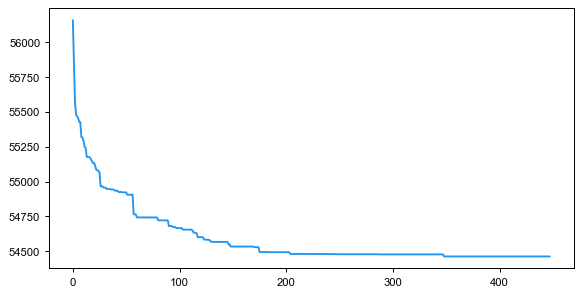

In [18]:
### carbon value in each successful optimization step
optimization_history.plot()

**Improvement over initially random scheduling**

In [19]:
(1-(optimization_history.min()/optimization_history.max()))*100

3.0189746189303257

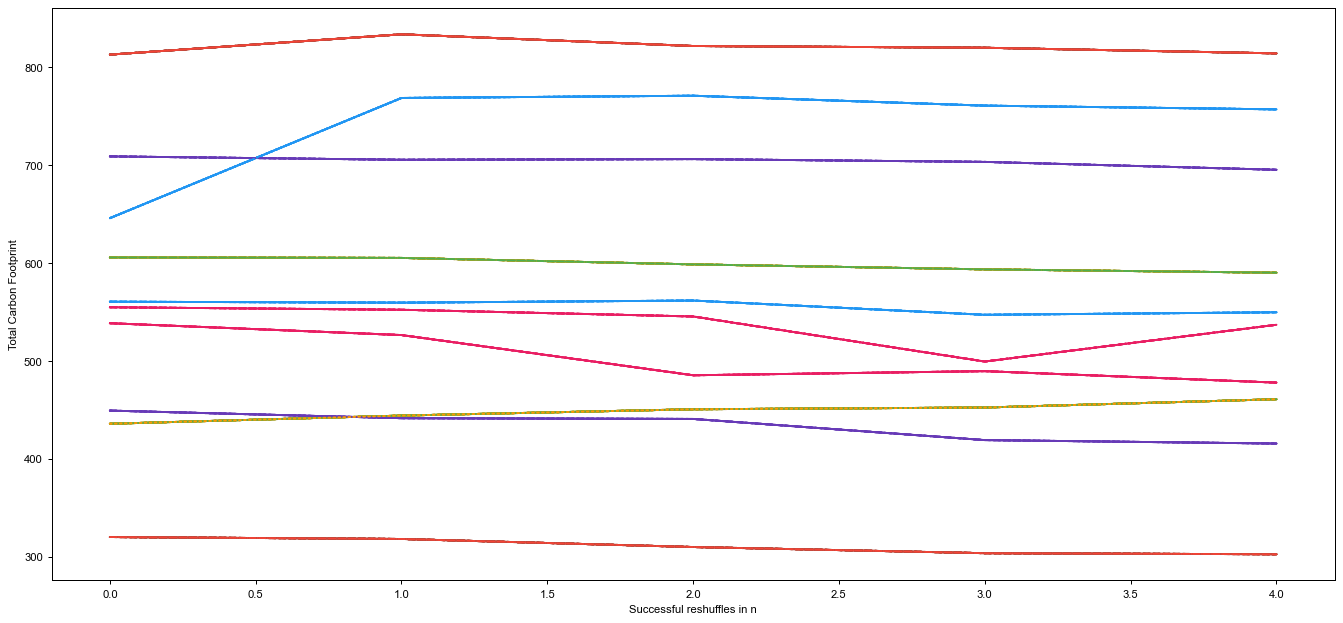

In [20]:
debug_plot_02 = plt.figure(figsize=(15, 7))
debug_plot_02.set_tight_layout(True)
debug_plot_02_ax1 = debug_plot_02.add_subplot(1, 1, 1)
debug_plot_02_ax1.set_xlabel('Successful reshuffles in n')
debug_plot_02_ax1.set_ylabel('Total Carbon Footprint')

for i, j in enumerate(cost):
    debug_plot_02_ax1.plot(range(len(j)), j, label=i)

# debug_plot_01_ax1.legend()